In [134]:
import os
import time
import datetime
from shutil import copyfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import xarray as xr
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
import copy

In [135]:
BASE_PATH_DATA = 'data/skogsstyrelsen/'
BAND_NAMES = ['b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b8a', 'b09', 'b11', 'b12']

In [136]:
# Read data + corresponding json info (incl ground truth)
img_paths_train = list(np.load(os.path.join(BASE_PATH_DATA, 'skogs_names_train.npy')))
img_paths_train = [path[1:] for path in img_paths_train]

img_paths_val = list(np.load(os.path.join(BASE_PATH_DATA, 'skogs_names_val.npy')))
img_paths_val = [path[1:] for path in img_paths_val]

img_paths_test = list(np.load(os.path.join(BASE_PATH_DATA, 'skogs_names_test.npy')))
img_paths_test = [path[1:] for path in img_paths_test]

json_content_train = list(np.load(os.path.join(BASE_PATH_DATA, 'skogs_json_train.npy'), allow_pickle=True))
json_content_val = list(np.load(os.path.join(BASE_PATH_DATA, 'skogs_json_val.npy'), allow_pickle=True))
json_content_test = list(np.load(os.path.join(BASE_PATH_DATA, 'skogs_json_test.npy'), allow_pickle=True))

train_label = list(np.load(os.path.join(BASE_PATH_DATA, "skogs_gts_train.npy")))
val_label = list(np.load(os.path.join(BASE_PATH_DATA, "skogs_gts_val.npy")))
test_label = list(np.load(os.path.join(BASE_PATH_DATA, "skogs_gts_test.npy")))

In [137]:
print(f'train size = {len(img_paths_train)}')
print(f'val size = {len(img_paths_val)}')
print(f'test size = {len(img_paths_test)}')

train size = 260
val size = 72
test size = 100


(0.0, 197.4)

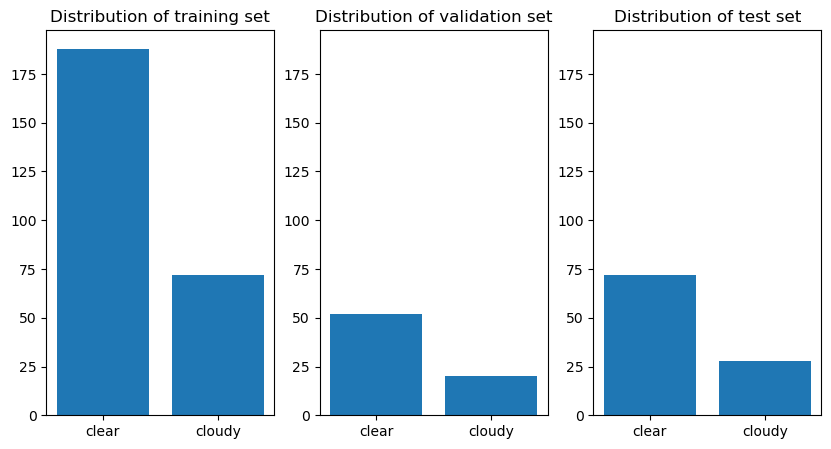

In [138]:
# plot distribution of each data set
labels = ["clear", "cloudy"]
labels_num = [0,1]
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))

# Bar for training
cloudy = np.count_nonzero(train_label)
clear = len(train_label) - cloudy
ax1.bar(labels_num, [clear,cloudy])
ax1.set_xticks(labels_num, labels)
ax1.set_title("Distribution of training set")
ylim = ax1.get_ylim()

# Bar for validation
cloudy = np.count_nonzero(val_label)
clear = len(val_label) - cloudy
ax2.bar(labels_num, [clear,cloudy])
ax2.set_xticks(labels_num, labels)
ax2.set_title("Distribution of validation set")
ax2.set_ylim(ylim)

# Bar for testing
cloudy = np.count_nonzero(test_label)
clear = len(test_label) - cloudy
ax3.bar(labels_num, [clear,cloudy])
ax3.set_xticks(labels_num, labels)
ax3.set_title("Distribution of test set")
ax3.set_ylim(ylim)


In [139]:
def load_image(path):
    img = xr.open_dataset(path)
    yy_mm_dd = getattr(img, 'time').values[0]
    yy = yy_mm_dd.astype('datetime64[Y]').astype(int) + 1970
    mm = yy_mm_dd.astype('datetime64[M]').astype(int) % 12 + 1

    band_list = []
    for band in BAND_NAMES:
        if yy >= 2022 and mm >= 1: # New normalization after Jan 2022
            band_list.append((getattr(img, band).values - 1000) / 10000)
        else:
            band_list.append(getattr(img, band).values / 10000) 
            
    img = np.concatenate(band_list, axis = 0)
    img = np.transpose(img, [1,2,0])
    img = np.fliplr(img).copy()
    img = np.flipud(img).copy()

    H, W = img.shape[:2]
    
    # padding
    if H != 21 and W != 21:
        zeros = np.zeros((1, 20, 12))
        img = np.concatenate((img, zeros), axis = 0)
        zeros = np.zeros((21, 1, 12))
        img = np.concatenate((img, zeros[:]), axis = 1)
        
    elif H != 21:
        zeros = np.zeros((1, 21, 12))
        img = np.concatenate((img, zeros), axis = 0)
        
    elif W != 21:
        zeros = np.zeros((21, 1, 12))
        img = np.concatenate((img, zeros[:]), axis = 1)
        
    return img

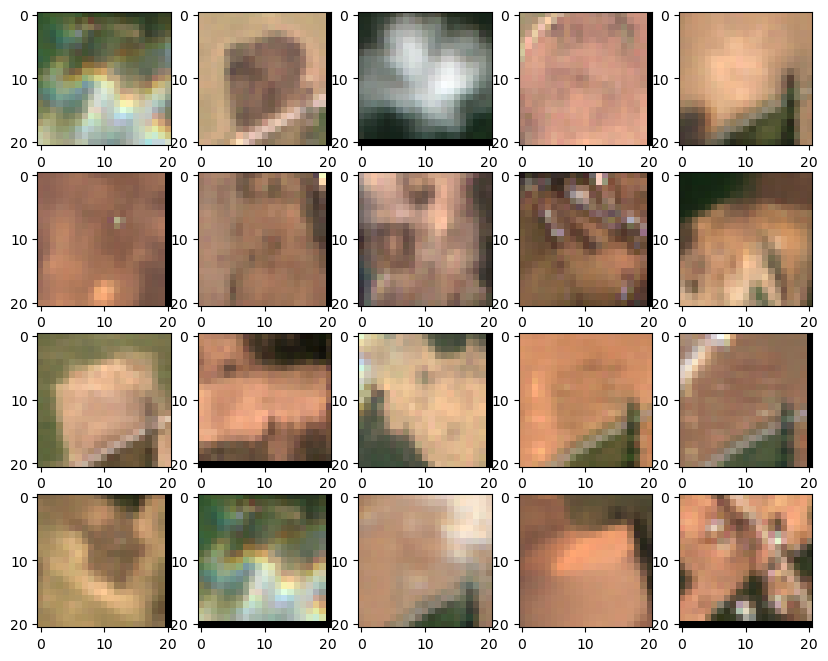

In [143]:
# show the first 20 images of the training set
def show_batch(batch): 
    columns = 5
    if len(batch) % 5 == 0:
        rows = int(len(batch)/5)
    else:
        rows = int(len(batch)/5) +1

    fig = plt.figure(figsize=(columns*2, rows*2)) 
    for i, img_path in enumerate(batch): 
        img = load_image(img_path)
        rgb_img = img[:, :, [3,2,1]]/np.max(img[:, :, [3,2,1]])
        fig.add_subplot(rows, columns, i+1) 
        plt.imshow(rgb_img, vmin=0, vmax=1)
    plt.show()
        
# show first 20 images of train data
show_batch(img_paths_train[:20])
    

In [144]:
network = nn.Sequential(
    nn.Linear(21*21*12, 21*21*12), 
    nn.ReLU(),
    nn.Linear(21*21*12, 21*21*12), 
    nn.ReLU(),
    nn.Linear(21*21*12, 21*21*12), 
    nn.ReLU(),
    nn.Linear(21*21*12, 1), 
    nn.Sigmoid()
)

loss_function = torch.nn.BCELoss()
optimizer = torch.optim.SGD(network.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)

Epoch 10 [260/260] - Loss: 0.37311002612113953545

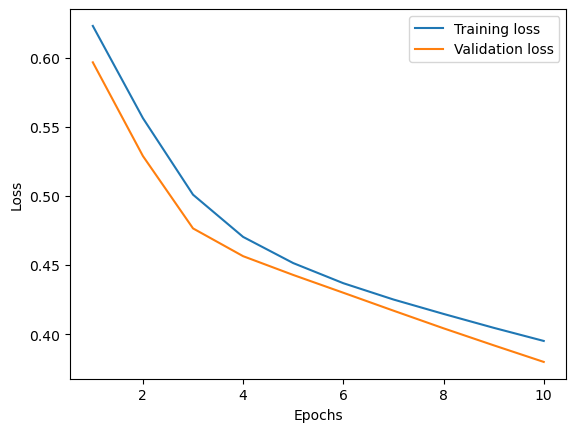

In [145]:
# Training loop
train_losses = []
val_losses = []

for epoch in range(10):
    losses = []
    
    for idx, path in enumerate(img_paths_train):
        label = train_label[idx]
        label = torch.tensor([[label]], dtype=torch.float32)
        
        img = load_image(path)
        img = img.reshape(1, 21*21*12)
        img = torch.tensor(img, dtype=torch.float32)

        pred = network(img)
        
        loss = loss_function(pred, label)
        
        loss.backward()
        
        optimizer.step()
        
        optimizer.zero_grad()

        losses.append(loss.item())

        # scheduler.step()
        
        print(
            '\rEpoch {} [{}/{}] - Loss: {}'.format(
                epoch+1, idx+1, len(img_paths_train), loss
            ),
            end=''
        )
        
    # take average loss of whole set
    train_losses.append(sum(losses)/len(losses))

    losses = []
    
    # validate
    for idx, path in enumerate(img_paths_val):
        label = val_label[idx]
        label = torch.tensor([[label]], dtype=torch.float32)
        
        img = load_image(path)
        img = img.reshape(1, 21*21*12)
        img = torch.tensor(img, dtype=torch.float32)

        pred = network(img)

        loss = loss_function(pred, label)
        losses.append(loss.item())

    # take average loss of whole set
    current_loss = sum(losses) / len(losses)

    # check if current epoch is best and save
    if (all(x > current_loss for x in val_losses)):
        best_model = copy.deepcopy(network)

    val_losses.append(current_loss)


# Plot training and validation loss per epoch
plt.plot(range(1,len(train_losses)+1), train_losses, label='Training loss')
plt.plot(range(1,len(val_losses)+1), val_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Final accuracy: 85.00%
Correct 85 times out of 100


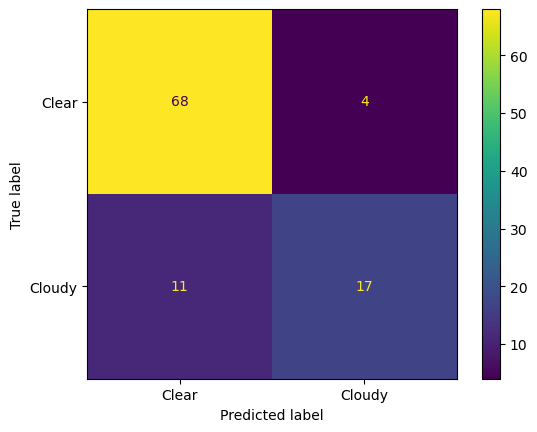

In [146]:
# Testing
correct = 0
wrong_cloudy = 0
wrong_not_cloudy = 0
preds = []

best_model.eval()

with torch.no_grad():
    for idx, path in enumerate(img_paths_test):
        img = load_image(path)
        img = img.reshape(1, 21*21*12)
        img = torch.tensor(img, dtype=torch.float32)

        pred = best_model(img).item()
        
        preds.append(round(pred))

for idx, pred in enumerate(preds):
    if pred == test_label[idx]:
        correct += 1
    
print("Final accuracy: %.2f%%" % (100*correct/len(test_label)))
print(f'Correct {correct} times out of {len(img_paths_test)}')


cm = confusion_matrix(test_label, preds)
ConfusionMatrixDisplay(confusion_matrix = cm,  display_labels=['Clear', 'Cloudy']).plot()